# VQE of the Z2 lattice gauge theory

In [ ]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import resource
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
import matplotlib
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter

## Prepare initial state and act on it with H1, H2, H3

In [2]:
numberofqubits=2
numberofmodes=3
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1) # To read out the results of the Hadamard test
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

diffstallmodes=[2,2,2]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

for i in range(numberofqubits):
    circuit.h(qbr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

theta_1=np.pi/2
theta_2=np.pi/2
theta_3=np.pi/2

# resource.vary_Z2LGT(circuit, numberofmodes, qmr, qbr, theta_1, theta_2, theta_3)
# circuit.barrier()
# for i in range(numberofqubits):
#     resource.measureE_fieldterm(circuit, qbr, i)
# for i in range(numberofmodes-1):
resource.vary_Z2LGT(circuit, numberofmodes, qmr, qbr, theta_1, theta_2, theta_3)
circuit.barrier()
resource.measureE_hoppingterm(circuit, numberofmodes, numberofqubits, qmr, qbr, 0)
circuit.barrier()
for i in range(numberofqubits):
    resource.measureE_fieldterm(circuit, qbr, i)

circuit.draw(output='mpl', filename='VQE_resourceH_measureE1.png')

stateop, result = c2qa.util.simulate(circuit)
# util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  222  qubits:  00     with amplitude: 0.500 + i0.000
qumodes:  222  qubits:  01     with amplitude: 0.500 + i0.000
qumodes:  222  qubits:  10     with amplitude: 0.500 + i0.000
qumodes:  222  qubits:  11     with amplitude: 0.500 + i0.000
occupation modes  [2.0, 2.0, 2.0]
occupation qubits  [0.4999999999999999, 0.4999999999999999]


/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/teague/Workspace/bosonic-isa/c2qa-qiskit/bosonEnv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Counts(ideal): {'0': 1024}


In [5]:
circuit.draw(output='mpl', filename='/home/richard/PycharmProjects/c2qa/c2qa-qiskit/tutorials/Z2-lattice-gauge-theory/images/VQE_resourceH_measureE1.png')

<Figure size 2617.72x1571.89 with 1 Axes>

## ECD protocol for creating the hopping term in H for VQE

/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


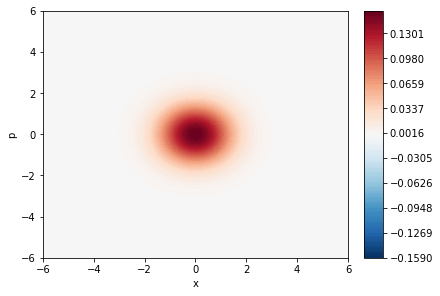

In [2]:
# The C2QA pacakge is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

import c2qa
import qiskit
import numpy as np

# Augment the number of qubits per mode
qmr = c2qa.QumodeRegister(num_qumodes=2, num_qubits_per_qumode=2)
qbr = qiskit.QuantumRegister(size=1)
qc = c2qa.CVCircuit(qmr, qbr)

# Initialize your qubit (should have no effect on Fock state Wigner function)
qc.initialize([1,0], qbr[0])

# initialise in x (just h) or y eigenstate
qc.h(qbr[0])
qc.rz(np.pi/2,qbr[0])

# Initialize the qumode to a zero Fock sate (ie. the vaccuum)
qc.cv_initialize(0, qmr[0])
qc.cv_initialize(0, qmr[1])

qc.cv_rh1(1, qmr[0], qmr[1], qbr[0])

state, _ = c2qa.util.simulate(qc)
c2qa.util.plot_wigner(qc, state)

## Measuring $\langle H \rangle$

For a given value of $\lambda$ and ansatz parameters $\vec{\theta}$ we can measure the expected energy
$\langle H \rangle$ by splitting the Hamiltonian into two parts $H = H_0 + H_1$.

## Measuring $\langle O_{n,n'} \rangle$

Using the conditional displacement operator we can measure $\sin (k \hat{x})$ of an oscillator using phase kickback.

In [17]:
%matplotlib inline

In [3]:
def measure_sin(input_circuit, qumode_reg, qubit_reg, bit_reg, alpha=1, verbose=0, shots=8192):
    
    input_circuit.h(qubit_reg[0])
    input_circuit.cv_cnd_d(alpha, -alpha, qubit_reg[0], qumode_reg[0])
    input_circuit.s(qubit_reg[0])
    input_circuit.h(qubit_reg[0])
    
    input_circuit.measure(qubit_reg[0], bit_reg[0])
    
    if verbose:
        print(input_circuit.draw())
    
    state, result = c2qa.util.simulate(circuit, shots=shots)
    counts = result.get_counts()
    
    if verbose:
        print(counts)
    
    # Compute <sigma_y>
    return (counts['0'] - counts['1']) / shots

In [4]:
qmr = c2qa.QumodeRegister(num_qumodes=1,
                          num_qubits_per_qumode=3,
                          name='qumode')
qr = qiskit.QuantumRegister(size=1, name='qubit')
cr = qiskit.ClassicalRegister(size=1, name='creg')
circuit = c2qa.CVCircuit(qmr, qr, cr)

circuit.cv_initialize(0, qmr[0])
#circuit.cv_s(0.5, qmr[0])
#circuit.cv_r(np.pi/8, qmr[0])
circuit.cv_d(np.pi/2, qmr[0])

state, result = c2qa.util.simulate(circuit)
c2qa.util.plot_wigner(circuit, state)

measure_sin(circuit, qmr, qr, cr, verbose=1, alpha=2j)

          ┌──────────────────────────────┐┌────┐┌─────┐             
qumode_0: ┤0                             ├┤0   ├┤1    ├─────────────
          │                              ││    ││     │             
qumode_1: ┤1 initialize(1,0,0,0,0,0,0,0) ├┤1 D ├┤2    ├─────────────
          │                              ││    ││  Dc │             
qumode_2: ┤2                             ├┤2   ├┤3    ├─────────────
          └────────────┬───┬─────────────┘└────┘│     │┌───┐┌───┐┌─┐
 qubit_0: ─────────────┤ H ├────────────────────┤0    ├┤ S ├┤ H ├┤M├
                       └───┘                    └─────┘└───┘└───┘└╥┘
  creg: 1/════════════════════════════════════════════════════════╩═
                                                                  0 
{'1': 6899, '0': 1293}


-0.684326171875

In [12]:
# Measure the coordinate x_hat of the oscillator
x_displacement = np.pi / 6

# A purely imaginary alpha will give the oscillator a momentum boost (Eqn 16)
# equivalently, this can be pictured as a rotation of the ancilla qubit
# about the Z-axis by an angle  theta(x) = -4kx
alpha_vals = np.arange(-0.5, 0.5, 0.05)
measured_vals = []
for alpha in alpha_vals:
    qmr = c2qa.QumodeRegister(num_qumodes=1,
                              num_qubits_per_qumode=3,
                              name='qumode')
    qr = qiskit.QuantumRegister(size=1, name='qubit')
    cr = qiskit.ClassicalRegister(size=1, name='creg')
    circuit = c2qa.CVCircuit(qmr, qr, cr)

    circuit.cv_initialize(0, qmr[0])
    circuit.cv_d(np.pi/2, qmr[0])

    # Measuring <sigma_y> = <sin[theta(x_hat)]> = -<sin[4k(x_hat)]>
    measured_vals.append(measure_sin(circuit, qmr, qr, cr, alpha=alpha*1j))

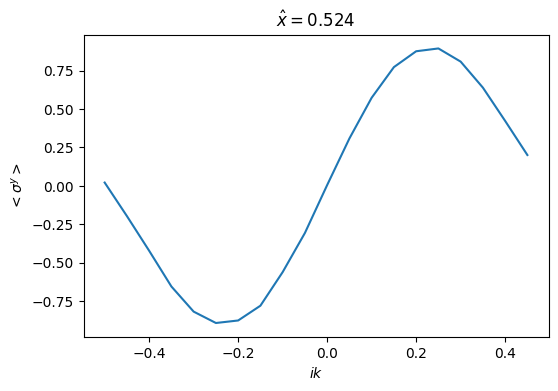

In [19]:
# Plot the expectation of <sigma_y> on the ancilla qubit
fig, ax = plt.subplots(dpi=100)
ax.plot(alpha_vals, measured_vals)
ax.set_ylabel('$<\sigma^y>$')
ax.set_xlabel('$ik$')
ax.set_title('$\hat{x} =$' + f'{x_displacement:.3f}')

plt.show()
plt.close()

-0.5000, 0.0212, 0.0106
-0.4500, -0.1970, -0.1102
-0.4000, -0.4229, -0.2729
-0.3500, -0.6555, -0.5106
-0.3000, -0.8191, -0.7999
-0.2500, -0.8931, -1.1041
-0.2000, -0.8767, -1.3362
-0.1500, -0.7805, -1.4925
-0.1000, -0.5618, -1.4913
-0.0500, -0.3071, -1.5609
-0.0000, 0.0049, 10995159968895.4238
0.0500, 0.3081, -1.5660
0.1000, 0.5732, -1.5261
0.1500, 0.7727, -1.4718
0.2000, 0.8760, -1.3343
0.2500, 0.8943, -1.1068
0.3000, 0.8086, -0.7848
0.3500, 0.6392, -0.4953
0.4000, 0.4226, -0.2727
0.4500, 0.2004, -0.1121


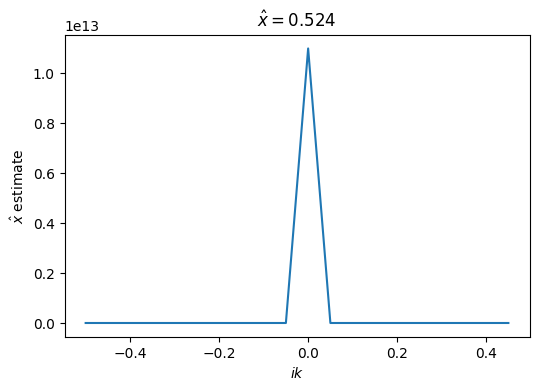

In [22]:
# Estimate the value of x_hat from the measured data
x_estimates = []
for val, k in zip(measured_vals, alpha_vals):
    x_hat = np.arcsin(-1 * val) / (4 * k) # computation can be vectorized to speedup
    print(f'{k:.4f}, {val:.4f}, {x_hat:.4f}')
    x_estimates.append(x_hat)

fig, ax = plt.subplots(dpi=100)
ax.plot(alpha_vals, x_estimates)
ax.set_ylabel('$\hat{x}$ estimate')
ax.set_xlabel('$ik$')
ax.set_title('$\hat{x} =$' + f'{x_displacement:.3f}')

plt.show()
plt.close()